# Constructing a corpus of cigarette adverts

In [28]:
import pandas as pd
import os
from tqdm import tqdm
import re
from itertools import chain
import unidecode
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt


In [83]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [30]:
data_path = '../../../../Dropbox/datasets/newspapers_clean/'
figures_path = '../ms/figures/'
output_path = '../data/'

In [31]:
keywords = [r'[a-z]*[cs]igaret\w*'] #this regular expressions captures spelling variations of cigarette in Dutch
pattern = '|'.join(keywords)


## Functions

In [89]:
def plot_ad_curve(df, freq, rolling=5):
    
    start_year = df['years'].min()
    end_year = df['years'].max()

    total_counts = df.groupby(pd.Grouper(key='date', freq=freq))['page'].count()
    
    plt.figure(figsize=(16, 10), dpi=80)
    for keyword in ['american', 'british', 'egyptian', 'virginia',
             'turkish', 'russian']:
        print(keyword)
        count = df.groupby(pd.Grouper(key='date', freq=freq))[keyword].sum().rolling(rolling).sum()
        rel_count = (count / total_counts) * 1000
        plt.plot(rel_count, lw=3, label=keyword)
    plt.legend(prop={'size': 15})
    #plt.title('Signifiers of Nationality in Cigarette Advertisements, 1890-1990', fontsize=22)
    #plt.xticks(fontsize=12, alpha=.7)
    #plt.yticks(fontsize=12, alpha=.7)
    plt.ylabel(r'Counts per 1,000 Ads', fontsize=15, alpha=.7)
    #plt.xlabel(r'Year', fontsize=15, alpha=.7)
    plt.grid(axis='both', alpha=.3)
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    plt.savefig(os.path.join(figures_path, 'cigarette_nationality.jpg'))
    
def find_context_word(text, span, keywords, context_term):
    '''
    Finding whether words appear in a certain span. 
    text = input text
    span = size of span
    keywords = central keyword
    context_term = words that can appear in context
    '''
    context = []
    counter = 0
    found_keywords = re.findall('|'.join(keywords),text)
    for keyword in found_keywords:
        list_words = text.split()
        for i in chain(range(span[0],0), range(1, span[1] + 1)):
            try:
                context.append(list_words[list_words.index(keyword) + i])
            except IndexError:
                pass

    matches = len(re.findall('|'.join(context_term), ' '.join(context)))
    counter += matches
    return counter


In [58]:
# This goes through the newspaper data and selects only ads with word cigarette in them. 
# Also, does some other preprocessing

results = []
subdirs = ['ads']
for root, dirs, files in os.walk(data_path):
    if all(subdir in dirs for subdir in subdirs):
        results.append(os.path.join(root,subdirs[0]))

# selected_papers = ['nn']
regex_pat = re.compile(r'[^a-zA-Z\s]', flags=re.IGNORECASE)
meta_data = []

for path in results:
    print(path)
    frame = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    onlyfiles = [f for f in onlyfiles if f.endswith('.tsv')]
    newspaper_name = path.split('/')[7]
    print(newspaper_name)
    newspaper_years = []
    for filename in tqdm(onlyfiles):
        print(filename)
        df = pd.read_csv(os.path.join(path, filename), index_col=None, delimiter='\t')
        df['ocr'] = df['ocr'].astype(str)
        df['ocr'] = df['ocr'].apply(lambda x: unidecode.unidecode(x)) 
        df['ocr'] = df['ocr'].str.replace(regex_pat, '') #only words
        df['ocr'] = df['ocr'].str.findall(r'\w{2,}').str.join(' ').str.lower() #only words longer than 2 chars
        df['identifier'] = df['ocr_url'].apply(lambda x: x.split('/')[:][3][12:-4])
        df = df[df['ocr'].str.contains(pattern, na=False)] #check for pattern
        #ocr = df[['identifier', 'ocr']]
        if 'paper_title' in df.columns: #nrc 
            df['newspaper_name'] = df['paper_title']
            df.drop(['issue_id', 'page_id', 'area'], axis=1, inplace=True)
        else:
            df['newspaper_name'] = newspaper_name
        #ocr.to_csv(os.path.join(path, 'ocr_' + filename), sep='\t', index=None)
        newspaper_years.append(df)
    frame = pd.concat(newspaper_years, axis=0, ignore_index=True)
    meta_data.append(frame)

cigarette_corpus = pd.concat(meta_data, axis=0, ignore_index=True)



  0%|          | 0/25 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/nrc/ads
nrc
nrc-1970.tsv


  4%|▍         | 1/25 [00:07<03:03,  7.64s/it]

nrc-1971.tsv


  8%|▊         | 2/25 [00:16<03:02,  7.93s/it]

nrc-1973.tsv


 12%|█▏        | 3/25 [00:25<03:00,  8.21s/it]

nrc-1972.tsv


 16%|█▌        | 4/25 [00:34<02:56,  8.43s/it]

nrc-1976.tsv


 20%|██        | 5/25 [00:42<02:47,  8.38s/it]

nrc-1989.tsv


 24%|██▍       | 6/25 [00:55<03:04,  9.69s/it]

nrc-1988.tsv


 28%|██▊       | 7/25 [01:07<03:09, 10.50s/it]

nrc-1977.tsv


 32%|███▏      | 8/25 [01:16<02:50, 10.03s/it]

nrc-1975.tsv


 36%|███▌      | 9/25 [01:25<02:33,  9.61s/it]

nrc-1974.tsv


 40%|████      | 10/25 [01:33<02:19,  9.28s/it]

nrc-1979.tsv


 44%|████▍     | 11/25 [01:43<02:13,  9.50s/it]

nrc-1992.tsv


 48%|████▊     | 12/25 [01:54<02:09,  9.99s/it]

nrc-1986.tsv


 52%|█████▏    | 13/25 [02:06<02:05, 10.47s/it]

nrc-1987.tsv


 56%|█████▌    | 14/25 [02:18<02:02, 11.15s/it]

nrc-1993.tsv


 60%|██████    | 15/25 [02:26<01:40, 10.07s/it]

nrc-1978.tsv


 64%|██████▍   | 16/25 [02:36<01:28,  9.88s/it]

nrc-1985.tsv


 68%|██████▊   | 17/25 [02:47<01:23, 10.47s/it]

nrc-1991.tsv


 72%|███████▏  | 18/25 [02:59<01:16, 10.93s/it]

nrc-1990.tsv


 76%|███████▌  | 19/25 [03:09<01:03, 10.56s/it]

nrc-1984.tsv


 80%|████████  | 20/25 [03:19<00:52, 10.41s/it]

nrc-1980.tsv


 84%|████████▍ | 21/25 [03:29<00:41, 10.32s/it]

nrc-1994.tsv


 88%|████████▊ | 22/25 [03:42<00:33, 11.09s/it]

nrc-1981.tsv


 92%|█████████▏| 23/25 [03:54<00:22, 11.22s/it]

nrc-1983.tsv


 96%|█████████▌| 24/25 [04:03<00:10, 10.71s/it]

nrc-1982.tsv


  0%|          | 0/106 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/detijd/ads
detijd
de_tijd_ads_1957.tsv


  1%|          | 1/106 [00:02<04:24,  2.52s/it]

de_tijd_ads_1943.tsv


  2%|▏         | 2/106 [00:04<04:17,  2.47s/it]

de_tijd_ads_1994.tsv
de_tijd_ads_1980.tsv
de_tijd_ads_1981.tsv
de_tijd_ads_1995.tsv
de_tijd_ads_1942.tsv


  7%|▋         | 7/106 [00:09<03:20,  2.02s/it]

de_tijd_ads_1956.tsv


  8%|▊         | 8/106 [00:12<03:36,  2.21s/it]

de_tijd_ads_1968.tsv
de_tijd_ads_1940.tsv


  9%|▉         | 10/106 [00:15<03:14,  2.03s/it]

de_tijd_ads_1954.tsv


 10%|█         | 11/106 [00:16<02:54,  1.84s/it]

de_tijd_ads_1983.tsv
de_tijd_ads_1982.tsv
de_tijd_ads_1955.tsv


 13%|█▎        | 14/106 [00:19<02:22,  1.55s/it]

de_tijd_ads_1941.tsv


 14%|█▍        | 15/106 [00:24<03:52,  2.56s/it]

de_tijd_ads_1969.tsv
de_tijd_ads_1945.tsv


 16%|█▌        | 17/106 [00:26<03:01,  2.04s/it]

de_tijd_ads_1951.tsv


 17%|█▋        | 18/106 [00:28<02:59,  2.03s/it]

de_tijd_ads_1979.tsv
de_tijd_ads_1986.tsv
de_tijd_ads_1992.tsv
de_tijd_ads_1993.tsv
de_tijd_ads_1987.tsv
de_tijd_ads_1978.tsv
de_tijd_ads_1950.tsv


 24%|██▎       | 25/106 [00:30<02:02,  1.51s/it]

de_tijd_ads_1944.tsv


 25%|██▍       | 26/106 [00:31<01:47,  1.34s/it]

de_tijd_ads_1952.tsv


 25%|██▌       | 27/106 [00:31<01:32,  1.18s/it]

de_tijd_ads_1946.tsv


 26%|██▋       | 28/106 [00:33<01:42,  1.32s/it]

de_tijd_ads_1991.tsv
de_tijd_ads_1985.tsv
de_tijd_ads_1984.tsv
de_tijd_ads_1990.tsv
de_tijd_ads_1947.tsv
de_tijd_ads_1953.tsv


 32%|███▏      | 34/106 [00:34<01:08,  1.05it/s]

de_tijd_ads_1897.tsv


 33%|███▎      | 35/106 [00:36<01:26,  1.23s/it]

de_tijd_ads_1908.tsv


 34%|███▍      | 36/106 [00:38<01:48,  1.54s/it]

de_tijd_ads_1934.tsv


 35%|███▍      | 37/106 [00:43<02:56,  2.56s/it]

de_tijd_ads_1920.tsv


 36%|███▌      | 38/106 [00:45<02:54,  2.57s/it]

de_tijd_ads_1921.tsv


 37%|███▋      | 39/106 [00:48<02:44,  2.45s/it]

de_tijd_ads_1935.tsv


 38%|███▊      | 40/106 [00:53<03:32,  3.22s/it]

de_tijd_ads_1909.tsv


 39%|███▊      | 41/106 [00:55<03:12,  2.96s/it]

de_tijd_ads_1896.tsv


 40%|███▉      | 42/106 [00:57<02:47,  2.62s/it]

de_tijd_ads_1894.tsv


 41%|████      | 43/106 [00:58<02:28,  2.35s/it]

de_tijd_ads_1923.tsv


 42%|████▏     | 44/106 [01:01<02:22,  2.30s/it]

de_tijd_ads_1937.tsv


 42%|████▏     | 45/106 [01:05<02:57,  2.90s/it]

de_tijd_ads_1936.tsv


 43%|████▎     | 46/106 [01:10<03:27,  3.47s/it]

de_tijd_ads_1922.tsv


 44%|████▍     | 47/106 [01:12<03:01,  3.08s/it]

de_tijd_ads_1895.tsv


 45%|████▌     | 48/106 [01:14<02:44,  2.83s/it]

de_tijd_ads_1891.tsv


 46%|████▌     | 49/106 [01:16<02:26,  2.57s/it]

de_tijd_ads_1926.tsv


 47%|████▋     | 50/106 [01:18<02:17,  2.45s/it]

de_tijd_ads_1932.tsv


 48%|████▊     | 51/106 [01:21<02:23,  2.60s/it]

de_tijd_ads_1933.tsv


 49%|████▉     | 52/106 [01:26<02:49,  3.15s/it]

de_tijd_ads_1927.tsv


 50%|█████     | 53/106 [01:28<02:36,  2.95s/it]

de_tijd_ads_1890.tsv


 51%|█████     | 54/106 [01:30<02:14,  2.60s/it]

de_tijd_ads_1892.tsv


 52%|█████▏    | 55/106 [01:32<02:00,  2.36s/it]

de_tijd_ads_1931.tsv


 53%|█████▎    | 56/106 [01:34<01:58,  2.36s/it]

de_tijd_ads_1925.tsv


 54%|█████▍    | 57/106 [01:37<01:58,  2.41s/it]

de_tijd_ads_1919.tsv


 55%|█████▍    | 58/106 [01:39<01:59,  2.49s/it]

de_tijd_ads_1918.tsv


 56%|█████▌    | 59/106 [01:42<01:55,  2.45s/it]

de_tijd_ads_1924.tsv


 57%|█████▋    | 60/106 [01:44<01:50,  2.40s/it]

de_tijd_ads_1930.tsv


 58%|█████▊    | 61/106 [01:47<01:51,  2.48s/it]

de_tijd_ads_1893.tsv


 58%|█████▊    | 62/106 [01:49<01:42,  2.34s/it]

de_tijd_ads_1929.tsv


 59%|█████▉    | 63/106 [01:51<01:37,  2.26s/it]

de_tijd_ads_1915.tsv


 60%|██████    | 64/106 [01:53<01:31,  2.18s/it]

de_tijd_ads_1901.tsv


 61%|██████▏   | 65/106 [01:55<01:32,  2.25s/it]

de_tijd_ads_1900.tsv


 62%|██████▏   | 66/106 [01:57<01:31,  2.29s/it]

de_tijd_ads_1914.tsv


 63%|██████▎   | 67/106 [01:59<01:26,  2.21s/it]

de_tijd_ads_1928.tsv


 64%|██████▍   | 68/106 [02:02<01:23,  2.21s/it]

de_tijd_ads_1902.tsv


 65%|██████▌   | 69/106 [02:04<01:24,  2.29s/it]

de_tijd_ads_1916.tsv


 66%|██████▌   | 70/106 [02:07<01:24,  2.35s/it]

de_tijd_ads_1917.tsv


 67%|██████▋   | 71/106 [02:09<01:23,  2.39s/it]

de_tijd_ads_1903.tsv


 68%|██████▊   | 72/106 [02:12<01:21,  2.39s/it]

de_tijd_ads_1898.tsv


 69%|██████▉   | 73/106 [02:14<01:18,  2.39s/it]

de_tijd_ads_1907.tsv


 70%|██████▉   | 74/106 [02:17<01:18,  2.45s/it]

de_tijd_ads_1913.tsv


 71%|███████   | 75/106 [02:18<01:03,  2.05s/it]

de_tijd_ads_1912.tsv


 72%|███████▏  | 76/106 [02:20<01:03,  2.11s/it]

de_tijd_ads_1906.tsv


 73%|███████▎  | 77/106 [02:23<01:05,  2.27s/it]

de_tijd_ads_1899.tsv


 74%|███████▎  | 78/106 [02:25<01:05,  2.33s/it]

de_tijd_ads_1910.tsv


 75%|███████▍  | 79/106 [02:27<01:03,  2.34s/it]

de_tijd_ads_1904.tsv


 75%|███████▌  | 80/106 [02:30<01:00,  2.32s/it]

de_tijd_ads_1938.tsv


 76%|███████▋  | 81/106 [02:34<01:12,  2.90s/it]

de_tijd_ads_1939.tsv


 77%|███████▋  | 82/106 [02:39<01:27,  3.65s/it]

de_tijd_ads_1905.tsv


 78%|███████▊  | 83/106 [02:42<01:15,  3.28s/it]

de_tijd_ads_1911.tsv


 79%|███████▉  | 84/106 [02:44<01:02,  2.84s/it]

de_tijd_ads_1976.tsv
de_tijd_ads_1962.tsv
de_tijd_ads_1989.tsv
de_tijd_ads_1988.tsv
de_tijd_ads_1963.tsv
de_tijd_ads_1977.tsv
de_tijd_ads_1949.tsv


 86%|████████▌ | 91/106 [02:45<00:30,  2.06s/it]

de_tijd_ads_1961.tsv
de_tijd_ads_1975.tsv
de_tijd_ads_1974.tsv
de_tijd_ads_1960.tsv
de_tijd_ads_1948.tsv


 91%|█████████ | 96/106 [02:47<00:15,  1.53s/it]

de_tijd_ads_1964.tsv
de_tijd_ads_1970.tsv
de_tijd_ads_1958.tsv


  0%|          | 0/21 [00:00<?, ?it/s]

de_tijd_ads_1959.tsv
de_tijd_ads_1971.tsv
de_tijd_ads_1965.tsv
de_tijd_ads_1973.tsv
de_tijd_ads_1967.tsv
de_tijd_ads_1966.tsv
de_tijd_ads_1972.tsv
../../../../Dropbox/datasets/newspapers_clean/nieuwe_rotterdamsche_courant/ads
nieuwe_rotterdamsche_courant
nieuwe_rotterdamsche_courant_ads_1927.tsv


  5%|▍         | 1/21 [00:10<03:30, 10.52s/it]

nieuwe_rotterdamsche_courant_ads_1926.tsv


 10%|▉         | 2/21 [00:20<03:18, 10.44s/it]

nieuwe_rotterdamsche_courant_ads_1918.tsv


 14%|█▍        | 3/21 [00:29<03:00, 10.01s/it]

nieuwe_rotterdamsche_courant_ads_1924.tsv


 19%|█▉        | 4/21 [00:35<02:30,  8.82s/it]

nieuwe_rotterdamsche_courant_ads_1925.tsv


 24%|██▍       | 5/21 [00:45<02:26,  9.17s/it]

nieuwe_rotterdamsche_courant_ads_1919.tsv


 29%|██▊       | 6/21 [00:56<02:24,  9.62s/it]

nieuwe_rotterdamsche_courant_ads_1921.tsv


 33%|███▎      | 7/21 [01:04<02:06,  9.07s/it]

nieuwe_rotterdamsche_courant_ads_1909.tsv


 38%|███▊      | 8/21 [01:04<01:24,  6.52s/it]

nieuwe_rotterdamsche_courant_ads_1920.tsv


 43%|████▎     | 9/21 [01:13<01:25,  7.16s/it]

nieuwe_rotterdamsche_courant_ads_1922.tsv


 48%|████▊     | 10/21 [01:18<01:12,  6.63s/it]

nieuwe_rotterdamsche_courant_ads_1923.tsv


 52%|█████▏    | 11/21 [01:25<01:06,  6.65s/it]

nieuwe_rotterdamsche_courant_ads_1912.tsv


 57%|█████▋    | 12/21 [01:32<01:00,  6.70s/it]

nieuwe_rotterdamsche_courant_ads_1913.tsv


 62%|██████▏   | 13/21 [01:38<00:52,  6.57s/it]

nieuwe_rotterdamsche_courant_ads_1911.tsv


 67%|██████▋   | 14/21 [01:44<00:45,  6.45s/it]

nieuwe_rotterdamsche_courant_ads_1910.tsv


 71%|███████▏  | 15/21 [01:51<00:39,  6.65s/it]

nieuwe_rotterdamsche_courant_ads_1914.tsv


 76%|███████▌  | 16/21 [01:57<00:31,  6.40s/it]

nieuwe_rotterdamsche_courant_ads_1928.tsv


 81%|████████  | 17/21 [02:07<00:29,  7.47s/it]

nieuwe_rotterdamsche_courant_ads_1929.tsv


 86%|████████▌ | 18/21 [02:17<00:24,  8.27s/it]

nieuwe_rotterdamsche_courant_ads_1915.tsv


 90%|█████████ | 19/21 [02:23<00:14,  7.43s/it]

nieuwe_rotterdamsche_courant_ads_1917.tsv


 95%|█████████▌| 20/21 [02:30<00:07,  7.48s/it]

nieuwe_rotterdamsche_courant_ads_1916.tsv


  0%|          | 0/105 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/nn/ads
nn
nieuwsblad_noorden_1901.tsv


  1%|          | 1/105 [00:05<10:21,  5.97s/it]

nieuwsblad_noorden_1915.tsv


  2%|▏         | 2/105 [00:16<12:22,  7.21s/it]

nieuwsblad_noorden_1929.tsv


  3%|▎         | 3/105 [00:28<14:57,  8.80s/it]

nieuwsblad_noorden_1928.tsv


  4%|▍         | 4/105 [00:40<16:31,  9.82s/it]

nieuwsblad_noorden_1914.tsv


  5%|▍         | 5/105 [00:48<15:33,  9.34s/it]

nieuwsblad_noorden_1900.tsv


  6%|▌         | 6/105 [00:51<12:16,  7.44s/it]

nieuwsblad_noorden_1916.tsv


  7%|▋         | 7/105 [01:01<13:22,  8.19s/it]

nieuwsblad_noorden_1902.tsv


  8%|▊         | 8/105 [01:08<12:28,  7.72s/it]

nieuwsblad_noorden_1903.tsv


  9%|▊         | 9/105 [01:12<10:32,  6.59s/it]

nieuwsblad_noorden_1917.tsv


 10%|▉         | 10/105 [01:23<12:25,  7.84s/it]

nieuwsblad_noorden_1913.tsv


 10%|█         | 11/105 [01:34<13:57,  8.91s/it]

nieuwsblad_noorden_1907.tsv


 11%|█▏        | 12/105 [01:42<13:29,  8.70s/it]

nieuwsblad_noorden_1898.tsv


 12%|█▏        | 13/105 [01:44<10:18,  6.72s/it]

nieuwsblad_noorden_1899.tsv


 13%|█▎        | 14/105 [01:47<08:12,  5.42s/it]

nieuwsblad_noorden_1906.tsv


 14%|█▍        | 15/105 [01:55<09:14,  6.16s/it]

nieuwsblad_noorden_1912.tsv


 15%|█▌        | 16/105 [02:05<10:51,  7.32s/it]

nieuwsblad_noorden_1938.tsv


 16%|█▌        | 17/105 [02:15<12:03,  8.22s/it]

nieuwsblad_noorden_1904.tsv


 17%|█▋        | 18/105 [02:23<11:35,  8.00s/it]

nieuwsblad_noorden_1910.tsv


 18%|█▊        | 19/105 [02:29<10:55,  7.63s/it]

nieuwsblad_noorden_1911.tsv


 19%|█▉        | 20/105 [02:42<12:58,  9.16s/it]

nieuwsblad_noorden_1905.tsv


 20%|██        | 21/105 [02:45<10:09,  7.26s/it]

nieuwsblad_noorden_1939.tsv


 21%|██        | 22/105 [02:54<10:44,  7.77s/it]

nieuwsblad_noorden_1989.tsv


 22%|██▏       | 23/105 [03:12<14:44, 10.78s/it]

nieuwsblad_noorden_1962.tsv


 23%|██▎       | 24/105 [03:16<12:06,  8.97s/it]

nieuwsblad_noorden_1976.tsv


 24%|██▍       | 25/105 [03:30<13:57, 10.47s/it]

nieuwsblad_noorden_1977.tsv


 25%|██▍       | 26/105 [03:47<16:02, 12.19s/it]

nieuwsblad_noorden_1963.tsv


 26%|██▌       | 27/105 [03:54<14:04, 10.83s/it]

nieuwsblad_noorden_1988.tsv


 27%|██▋       | 28/105 [04:12<16:25, 12.80s/it]

nieuwsblad_noorden_1975.tsv


 28%|██▊       | 29/105 [04:27<16:59, 13.42s/it]

nieuwsblad_noorden_1961.tsv


 29%|██▊       | 30/105 [04:35<14:55, 11.95s/it]

nieuwsblad_noorden_1949.tsv


 30%|██▉       | 31/105 [04:37<10:58,  8.90s/it]

nieuwsblad_noorden_1948.tsv


 30%|███       | 32/105 [04:39<08:32,  7.02s/it]

nieuwsblad_noorden_1960.tsv


 31%|███▏      | 33/105 [04:47<08:46,  7.31s/it]

nieuwsblad_noorden_1974.tsv


 32%|███▏      | 34/105 [05:02<11:12,  9.47s/it]

nieuwsblad_noorden_1958.tsv


 33%|███▎      | 35/105 [05:08<10:01,  8.59s/it]

nieuwsblad_noorden_1970.tsv


 34%|███▍      | 36/105 [05:23<11:55, 10.37s/it]

nieuwsblad_noorden_1964.tsv


 35%|███▌      | 37/105 [05:33<11:45, 10.37s/it]

nieuwsblad_noorden_1965.tsv


 36%|███▌      | 38/105 [05:45<12:04, 10.81s/it]

nieuwsblad_noorden_1971.tsv


 37%|███▋      | 39/105 [06:00<13:08, 11.95s/it]

nieuwsblad_noorden_1959.tsv


 38%|███▊      | 40/105 [06:07<11:32, 10.66s/it]

nieuwsblad_noorden_1967.tsv


 39%|███▉      | 41/105 [06:19<11:30, 10.79s/it]

nieuwsblad_noorden_1973.tsv


 40%|████      | 42/105 [06:33<12:22, 11.78s/it]

nieuwsblad_noorden_1972.tsv


 41%|████      | 43/105 [06:47<12:57, 12.55s/it]

nieuwsblad_noorden_1966.tsv


 42%|████▏     | 44/105 [06:59<12:34, 12.36s/it]

nieuwsblad_noorden_1980.tsv


 43%|████▎     | 45/105 [07:17<14:09, 14.17s/it]

nieuwsblad_noorden_1994.tsv


 44%|████▍     | 46/105 [07:31<13:39, 13.89s/it]

nieuwsblad_noorden_1943.tsv


 45%|████▍     | 47/105 [07:34<10:20, 10.70s/it]

nieuwsblad_noorden_1957.tsv


 46%|████▌     | 48/105 [07:41<09:04,  9.55s/it]

nieuwsblad_noorden_1956.tsv


 47%|████▋     | 49/105 [07:48<08:14,  8.83s/it]

nieuwsblad_noorden_1942.tsv


 48%|████▊     | 50/105 [07:53<07:05,  7.73s/it]

nieuwsblad_noorden_1981.tsv


 49%|████▊     | 51/105 [08:10<09:20, 10.38s/it]

nieuwsblad_noorden_1983.tsv


 50%|████▉     | 52/105 [08:25<10:32, 11.93s/it]

nieuwsblad_noorden_1954.tsv


 50%|█████     | 53/105 [08:31<08:43, 10.08s/it]

nieuwsblad_noorden_1940.tsv


 51%|█████▏    | 54/105 [08:38<07:48,  9.18s/it]

nieuwsblad_noorden_1968.tsv


 52%|█████▏    | 55/105 [08:50<08:27, 10.14s/it]

nieuwsblad_noorden_1969.tsv


 53%|█████▎    | 56/105 [09:02<08:42, 10.67s/it]

nieuwsblad_noorden_1941.tsv


 54%|█████▍    | 57/105 [09:08<07:21,  9.20s/it]

nieuwsblad_noorden_1955.tsv


 55%|█████▌    | 58/105 [09:11<05:46,  7.38s/it]

nieuwsblad_noorden_1982.tsv


 56%|█████▌    | 59/105 [09:27<07:35,  9.91s/it]

nieuwsblad_noorden_1992.tsv


 57%|█████▋    | 60/105 [09:43<08:52, 11.84s/it]

nieuwsblad_noorden_1986.tsv


 58%|█████▊    | 61/105 [10:00<09:47, 13.36s/it]

nieuwsblad_noorden_1979.tsv


 59%|█████▉    | 62/105 [10:20<11:01, 15.39s/it]

nieuwsblad_noorden_1951.tsv


 60%|██████    | 63/105 [10:25<08:31, 12.18s/it]

nieuwsblad_noorden_1945.tsv
nieuwsblad_noorden_1944.tsv


 62%|██████▏   | 65/105 [10:27<05:51,  8.80s/it]

nieuwsblad_noorden_1950.tsv


 63%|██████▎   | 66/105 [10:30<04:38,  7.13s/it]

nieuwsblad_noorden_1978.tsv


 64%|██████▍   | 67/105 [10:48<06:32, 10.34s/it]

nieuwsblad_noorden_1987.tsv


 65%|██████▍   | 68/105 [11:06<07:54, 12.82s/it]

nieuwsblad_noorden_1993.tsv


 66%|██████▌   | 69/105 [11:22<08:14, 13.74s/it]

nieuwsblad_noorden_1985.tsv


 67%|██████▋   | 70/105 [11:40<08:41, 14.89s/it]

nieuwsblad_noorden_1991.tsv


 68%|██████▊   | 71/105 [11:57<08:51, 15.62s/it]

nieuwsblad_noorden_1946.tsv


 69%|██████▊   | 72/105 [12:00<06:25, 11.68s/it]

nieuwsblad_noorden_1952.tsv


 70%|██████▉   | 73/105 [12:05<05:07,  9.61s/it]

nieuwsblad_noorden_1953.tsv


 70%|███████   | 74/105 [12:09<04:07,  7.98s/it]

nieuwsblad_noorden_1947.tsv


 71%|███████▏  | 75/105 [12:12<03:17,  6.59s/it]

nieuwsblad_noorden_1990.tsv


 72%|███████▏  | 76/105 [12:30<04:50, 10.03s/it]

nieuwsblad_noorden_1984.tsv


 73%|███████▎  | 77/105 [12:48<05:48, 12.44s/it]

nieuwsblad_noorden_1920.tsv


 74%|███████▍  | 78/105 [12:50<04:13,  9.40s/it]

nieuwsblad_noorden_1934.tsv


 75%|███████▌  | 79/105 [13:00<04:04,  9.39s/it]

nieuwsblad_noorden_1908.tsv


 76%|███████▌  | 80/105 [13:09<03:55,  9.43s/it]

nieuwsblad_noorden_1897.tsv


 77%|███████▋  | 81/105 [13:11<02:53,  7.23s/it]

nieuwsblad_noorden_1896.tsv


 78%|███████▊  | 82/105 [13:15<02:21,  6.16s/it]

nieuwsblad_noorden_1909.tsv


 79%|███████▉  | 83/105 [13:19<01:58,  5.38s/it]

nieuwsblad_noorden_1935.tsv


 80%|████████  | 84/105 [13:29<02:22,  6.80s/it]

nieuwsblad_noorden_1921.tsv
nieuwsblad_noorden_1937.tsv


 82%|████████▏ | 86/105 [13:42<02:07,  6.70s/it]

nieuwsblad_noorden_1923.tsv


 83%|████████▎ | 87/105 [13:58<02:50,  9.47s/it]

nieuwsblad_noorden_1894.tsv


 84%|████████▍ | 88/105 [14:00<02:03,  7.29s/it]

nieuwsblad_noorden_1895.tsv


 85%|████████▍ | 89/105 [14:02<01:32,  5.81s/it]

nieuwsblad_noorden_1922.tsv


 86%|████████▌ | 90/105 [14:11<01:38,  6.55s/it]

nieuwsblad_noorden_1936.tsv


 87%|████████▋ | 91/105 [14:20<01:42,  7.34s/it]

nieuwsblad_noorden_1932.tsv


 88%|████████▊ | 92/105 [14:30<01:46,  8.17s/it]

nieuwsblad_noorden_1926.tsv


 89%|████████▊ | 93/105 [14:41<01:48,  9.07s/it]

nieuwsblad_noorden_1891.tsv


 90%|████████▉ | 94/105 [14:42<01:12,  6.58s/it]

nieuwsblad_noorden_1890.tsv
nieuwsblad_noorden_1927.tsv


 91%|█████████▏| 96/105 [14:53<00:57,  6.36s/it]

nieuwsblad_noorden_1933.tsv


 92%|█████████▏| 97/105 [15:03<00:58,  7.34s/it]

nieuwsblad_noorden_1919.tsv


 93%|█████████▎| 98/105 [15:14<00:59,  8.43s/it]

nieuwsblad_noorden_1925.tsv


 94%|█████████▍| 99/105 [15:25<00:54,  9.09s/it]

nieuwsblad_noorden_1931.tsv


 95%|█████████▌| 100/105 [15:35<00:47,  9.50s/it]

nieuwsblad_noorden_1892.tsv


 96%|█████████▌| 101/105 [15:37<00:28,  7.07s/it]

nieuwsblad_noorden_1893.tsv


 97%|█████████▋| 102/105 [15:38<00:16,  5.41s/it]

nieuwsblad_noorden_1930.tsv


 98%|█████████▊| 103/105 [15:49<00:13,  6.96s/it]

nieuwsblad_noorden_1924.tsv


 99%|█████████▉| 104/105 [15:59<00:08,  8.12s/it]

nieuwsblad_noorden_1918.tsv


  0%|          | 0/99 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/telegraaf/ads
telegraaf
telegraaf_ads_1988.tsv


  1%|          | 1/99 [00:53<1:26:49, 53.15s/it]

telegraaf_ads_1977.tsv


  2%|▏         | 2/99 [01:56<1:31:04, 56.33s/it]

telegraaf_ads_1963.tsv


  3%|▎         | 3/99 [02:16<1:12:39, 45.41s/it]

telegraaf_ads_1962.tsv


  4%|▍         | 4/99 [02:34<58:48, 37.14s/it]  

telegraaf_ads_1976.tsv


  5%|▌         | 5/99 [03:19<1:01:58, 39.56s/it]

telegraaf_ads_1989.tsv


  6%|▌         | 6/99 [04:18<1:10:05, 45.22s/it]

telegraaf_ads_1960.tsv


  7%|▋         | 7/99 [04:34<55:47, 36.39s/it]  

telegraaf_ads_1974.tsv


  8%|▊         | 8/99 [05:20<59:37, 39.31s/it]

telegraaf_ads_1949.tsv


  9%|▉         | 9/99 [05:21<41:41, 27.79s/it]

telegraaf_ads_1975.tsv


 10%|█         | 10/99 [06:03<47:52, 32.28s/it]

telegraaf_ads_1961.tsv


 11%|█         | 11/99 [06:20<40:26, 27.57s/it]

telegraaf_ads_1959.tsv


 12%|█▏        | 12/99 [06:33<33:38, 23.20s/it]

telegraaf_ads_1965.tsv


 13%|█▎        | 13/99 [07:00<34:56, 24.37s/it]

telegraaf_ads_1971.tsv


 14%|█▍        | 14/99 [07:38<40:29, 28.58s/it]

telegraaf_ads_1970.tsv


 15%|█▌        | 15/99 [08:18<44:33, 31.82s/it]

telegraaf_ads_1964.tsv


 16%|█▌        | 16/99 [08:40<39:51, 28.81s/it]

telegraaf_ads_1958.tsv


 17%|█▋        | 17/99 [08:50<31:43, 23.21s/it]

telegraaf_ads_1972.tsv


 18%|█▊        | 18/99 [09:27<36:55, 27.35s/it]

telegraaf_ads_1966.tsv


 19%|█▉        | 19/99 [09:57<37:31, 28.15s/it]

telegraaf_ads_1967.tsv


 20%|██        | 20/99 [10:30<39:14, 29.81s/it]

telegraaf_ads_1973.tsv


 21%|██        | 21/99 [11:20<46:18, 35.62s/it]

telegraaf_ads_1914.tsv


 22%|██▏       | 22/99 [11:22<32:45, 25.53s/it]

telegraaf_ads_1900.tsv


 23%|██▎       | 23/99 [11:26<24:24, 19.27s/it]

telegraaf_ads_1928.tsv


 24%|██▍       | 24/99 [11:38<21:10, 16.95s/it]

telegraaf_ads_1929.tsv


 25%|██▌       | 25/99 [11:51<19:19, 15.67s/it]

telegraaf_ads_1901.tsv


 26%|██▋       | 26/99 [11:55<14:57, 12.30s/it]

telegraaf_ads_1915.tsv


 27%|██▋       | 27/99 [12:01<12:22, 10.31s/it]

telegraaf_ads_1903.tsv


 28%|██▊       | 28/99 [12:05<10:08,  8.57s/it]

telegraaf_ads_1917.tsv


 29%|██▉       | 29/99 [12:15<10:21,  8.88s/it]

telegraaf_ads_1916.tsv


 30%|███       | 30/99 [12:22<09:38,  8.38s/it]

telegraaf_ads_1902.tsv


 31%|███▏      | 31/99 [12:26<08:05,  7.13s/it]

telegraaf_ads_1899.tsv


 32%|███▏      | 32/99 [12:32<07:24,  6.63s/it]

telegraaf_ads_1906.tsv


 33%|███▎      | 33/99 [12:37<06:54,  6.27s/it]

telegraaf_ads_1912.tsv


 34%|███▍      | 34/99 [12:44<06:51,  6.33s/it]

telegraaf_ads_1913.tsv


 35%|███▌      | 35/99 [12:52<07:20,  6.88s/it]

telegraaf_ads_1907.tsv


 36%|███▋      | 36/99 [12:57<06:43,  6.40s/it]

telegraaf_ads_1898.tsv


 37%|███▋      | 37/99 [13:02<06:19,  6.12s/it]

telegraaf_ads_1939.tsv


 38%|███▊      | 38/99 [13:15<08:17,  8.16s/it]

telegraaf_ads_1911.tsv


 39%|███▉      | 39/99 [13:21<07:18,  7.31s/it]

telegraaf_ads_1905.tsv


 40%|████      | 40/99 [13:24<06:00,  6.11s/it]

telegraaf_ads_1904.tsv


 41%|████▏     | 41/99 [13:29<05:38,  5.83s/it]

telegraaf_ads_1910.tsv


 42%|████▏     | 42/99 [13:35<05:28,  5.76s/it]

telegraaf_ads_1938.tsv


 43%|████▎     | 43/99 [13:49<07:52,  8.44s/it]

telegraaf_ads_1896.tsv


 44%|████▍     | 44/99 [13:54<06:36,  7.20s/it]

telegraaf_ads_1935.tsv


 45%|████▌     | 45/99 [14:06<07:42,  8.56s/it]

telegraaf_ads_1921.tsv


 46%|████▋     | 46/99 [14:16<07:58,  9.04s/it]

telegraaf_ads_1909.tsv


 47%|████▋     | 47/99 [14:21<06:54,  7.98s/it]

telegraaf_ads_1908.tsv


 48%|████▊     | 48/99 [14:27<06:16,  7.37s/it]

telegraaf_ads_1920.tsv


 49%|████▉     | 49/99 [14:36<06:27,  7.76s/it]

telegraaf_ads_1934.tsv


 51%|█████     | 50/99 [14:51<08:06,  9.93s/it]

telegraaf_ads_1897.tsv


 52%|█████▏    | 51/99 [14:57<06:58,  8.71s/it]

telegraaf_ads_1895.tsv


 53%|█████▎    | 52/99 [15:01<05:48,  7.42s/it]

telegraaf_ads_1922.tsv


 54%|█████▎    | 53/99 [15:11<06:22,  8.31s/it]

telegraaf_ads_1936.tsv


 55%|█████▍    | 54/99 [15:25<07:27,  9.94s/it]

telegraaf_ads_1937.tsv


 56%|█████▌    | 55/99 [15:42<08:41, 11.85s/it]

telegraaf_ads_1923.tsv


 57%|█████▋    | 56/99 [15:53<08:24, 11.74s/it]

telegraaf_ads_1894.tsv


 58%|█████▊    | 57/99 [15:57<06:31,  9.32s/it]

telegraaf_ads_1927.tsv


 59%|█████▊    | 58/99 [16:09<06:57, 10.18s/it]

telegraaf_ads_1933.tsv


 60%|█████▉    | 59/99 [16:23<07:29, 11.25s/it]

telegraaf_ads_1932.tsv


 61%|██████    | 60/99 [16:36<07:46, 11.96s/it]

telegraaf_ads_1926.tsv


 62%|██████▏   | 61/99 [16:51<08:05, 12.78s/it]

telegraaf_ads_1893.tsv


 63%|██████▎   | 62/99 [16:53<05:54,  9.59s/it]

telegraaf_ads_1918.tsv


 64%|██████▎   | 63/99 [17:01<05:22,  8.95s/it]

telegraaf_ads_1930.tsv


 65%|██████▍   | 64/99 [17:18<06:38, 11.38s/it]

telegraaf_ads_1924.tsv


 66%|██████▌   | 65/99 [17:30<06:41, 11.82s/it]

telegraaf_ads_1925.tsv


 67%|██████▋   | 66/99 [17:40<06:10, 11.24s/it]

telegraaf_ads_1931.tsv


 68%|██████▊   | 67/99 [17:54<06:27, 12.11s/it]

telegraaf_ads_1919.tsv


 69%|██████▊   | 68/99 [18:05<05:58, 11.55s/it]

telegraaf_ads_1981.tsv


 70%|██████▉   | 69/99 [18:56<11:43, 23.45s/it]

telegraaf_ads_1956.tsv


 71%|███████   | 70/99 [19:06<09:19, 19.31s/it]

telegraaf_ads_1942.tsv


 72%|███████▏  | 71/99 [19:15<07:37, 16.35s/it]

telegraaf_ads_1943.tsv


 73%|███████▎  | 72/99 [19:20<05:52, 13.06s/it]

telegraaf_ads_1957.tsv


 74%|███████▎  | 73/99 [19:31<05:20, 12.32s/it]

telegraaf_ads_1980.tsv


 75%|███████▍  | 74/99 [20:25<10:22, 24.91s/it]

telegraaf_ads_1994.tsv


 76%|███████▌  | 75/99 [21:37<15:34, 38.93s/it]

telegraaf_ads_1982.tsv


 77%|███████▋  | 76/99 [22:25<15:57, 41.62s/it]

telegraaf_ads_1941.tsv


 78%|███████▊  | 77/99 [22:34<11:40, 31.84s/it]

telegraaf_ads_1955.tsv


 79%|███████▉  | 78/99 [22:44<08:52, 25.36s/it]

telegraaf_ads_1969.tsv


 80%|███████▉  | 79/99 [23:27<10:12, 30.64s/it]

telegraaf_ads_1968.tsv


 81%|████████  | 80/99 [24:05<10:22, 32.75s/it]

telegraaf_ads_1954.tsv


 82%|████████▏ | 81/99 [24:13<07:35, 25.29s/it]

telegraaf_ads_1940.tsv


 83%|████████▎ | 82/99 [24:21<05:42, 20.16s/it]

telegraaf_ads_1983.tsv


 84%|████████▍ | 83/99 [25:09<07:37, 28.60s/it]

telegraaf_ads_1987.tsv


 85%|████████▍ | 84/99 [26:11<09:38, 38.58s/it]

telegraaf_ads_1993.tsv


 86%|████████▌ | 85/99 [27:19<11:03, 47.39s/it]

telegraaf_ads_1978.tsv


 87%|████████▋ | 86/99 [28:26<11:31, 53.19s/it]

telegraaf_ads_1944.tsv


 88%|████████▊ | 87/99 [28:32<07:48, 39.07s/it]

telegraaf_ads_1950.tsv


 89%|████████▉ | 88/99 [28:35<05:12, 28.38s/it]

telegraaf_ads_1951.tsv


 90%|████████▉ | 89/99 [28:42<03:39, 21.96s/it]

telegraaf_ads_1945.tsv


 91%|█████████ | 90/99 [28:43<02:21, 15.67s/it]

telegraaf_ads_1979.tsv


 92%|█████████▏| 91/99 [29:41<03:45, 28.21s/it]

telegraaf_ads_1992.tsv


 93%|█████████▎| 92/99 [30:48<04:38, 39.81s/it]

telegraaf_ads_1986.tsv


 94%|█████████▍| 93/99 [31:44<04:28, 44.81s/it]

telegraaf_ads_1990.tsv


 95%|█████████▍| 94/99 [32:49<04:13, 50.78s/it]

telegraaf_ads_1984.tsv


 96%|█████████▌| 95/99 [33:41<03:25, 51.33s/it]

telegraaf_ads_1953.tsv


 97%|█████████▋| 96/99 [33:48<01:53, 37.93s/it]

telegraaf_ads_1952.tsv


 98%|█████████▊| 97/99 [33:53<00:56, 28.21s/it]

telegraaf_ads_1985.tsv


 99%|█████████▉| 98/99 [34:46<00:35, 35.64s/it]

telegraaf_ads_1991.tsv


  0%|          | 0/27 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/vaderland/ads
vaderland
vaderland_ads_1938.tsv


  4%|▎         | 1/27 [00:05<02:10,  5.02s/it]

vaderland_ads_1939.tsv


  7%|▋         | 2/27 [00:09<02:01,  4.87s/it]

vaderland_ads_1929.tsv


 11%|█         | 3/27 [00:16<02:10,  5.43s/it]

vaderland_ads_1928.tsv


 15%|█▍        | 4/27 [00:22<02:07,  5.56s/it]

vaderland_ads_1945.tsv


 19%|█▊        | 5/27 [00:22<01:27,  3.99s/it]

vaderland_ads_1944.tsv


 22%|██▏       | 6/27 [00:24<01:12,  3.44s/it]

vaderland_ads_1940.tsv


 26%|██▌       | 7/27 [00:28<01:10,  3.50s/it]

vaderland_ads_1941.tsv


 30%|██▉       | 8/27 [00:31<01:07,  3.55s/it]

vaderland_ads_1943.tsv


 33%|███▎      | 9/27 [00:34<00:59,  3.32s/it]

vaderland_ads_1942.tsv


 41%|████      | 11/27 [00:38<00:38,  2.43s/it]

vaderland_ads_1919.tsv
vaderland_ads_1931.tsv


 44%|████▍     | 12/27 [00:44<00:53,  3.57s/it]

vaderland_ads_1925.tsv


 48%|████▊     | 13/27 [00:49<00:54,  3.92s/it]

vaderland_ads_1924.tsv


 52%|█████▏    | 14/27 [00:53<00:53,  4.09s/it]

vaderland_ads_1930.tsv


 56%|█████▌    | 15/27 [01:00<00:57,  4.75s/it]

vaderland_ads_1926.tsv


 59%|█████▉    | 16/27 [01:05<00:52,  4.76s/it]

vaderland_ads_1932.tsv


 63%|██████▎   | 17/27 [01:10<00:50,  5.03s/it]

vaderland_ads_1933.tsv


 67%|██████▋   | 18/27 [01:16<00:47,  5.32s/it]

vaderland_ads_1927.tsv


 70%|███████   | 19/27 [01:22<00:43,  5.43s/it]

vaderland_ads_1923.tsv


 74%|███████▍  | 20/27 [01:27<00:36,  5.22s/it]

vaderland_ads_1937.tsv


 78%|███████▊  | 21/27 [01:32<00:31,  5.19s/it]

vaderland_ads_1936.tsv


 81%|████████▏ | 22/27 [01:37<00:25,  5.17s/it]

vaderland_ads_1922.tsv


 85%|████████▌ | 23/27 [01:41<00:19,  4.99s/it]

vaderland_ads_1934.tsv


 89%|████████▉ | 24/27 [01:47<00:15,  5.26s/it]

vaderland_ads_1920.tsv


 93%|█████████▎| 25/27 [01:52<00:10,  5.20s/it]

vaderland_ads_1921.tsv


 96%|█████████▋| 26/27 [01:57<00:05,  5.08s/it]

vaderland_ads_1935.tsv


  0%|          | 0/76 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/algemeen_handelsblad/ads
algemeen_handelsblad
ah_ads_1927.tsv


  1%|▏         | 1/76 [00:12<15:16, 12.22s/it]

ah_ads_1933.tsv


  3%|▎         | 2/76 [00:19<13:16, 10.77s/it]

ah_ads_1890.tsv
ah_ads_1891.tsv
ah_ads_1932.tsv


  7%|▋         | 5/76 [00:30<10:10,  8.60s/it]

ah_ads_1926.tsv


  8%|▊         | 6/76 [00:42<11:18,  9.69s/it]

ah_ads_1930.tsv


  9%|▉         | 7/76 [00:55<12:07, 10.55s/it]

ah_ads_1924.tsv


 11%|█         | 8/76 [01:03<11:22, 10.03s/it]

ah_ads_1918.tsv
ah_ads_1893.tsv
ah_ads_1892.tsv
ah_ads_1925.tsv


 16%|█▌        | 12/76 [01:16<08:29,  7.96s/it]

ah_ads_1931.tsv


 17%|█▋        | 13/76 [01:28<09:34,  9.12s/it]

ah_ads_1909.tsv


 18%|█▊        | 14/76 [01:29<06:54,  6.69s/it]

ah_ads_1935.tsv


 20%|█▉        | 15/76 [01:34<06:20,  6.23s/it]

ah_ads_1921.tsv


 21%|██        | 16/76 [01:45<07:49,  7.83s/it]

ah_ads_1896.tsv
ah_ads_1897.tsv
ah_ads_1920.tsv
ah_ads_1934.tsv


 26%|██▋       | 20/76 [01:52<05:33,  5.96s/it]

ah_ads_1908.tsv
ah_ads_1922.tsv


 29%|██▉       | 22/76 [01:55<04:07,  4.59s/it]

ah_ads_1936.tsv


 30%|███       | 23/76 [01:56<03:16,  3.70s/it]

ah_ads_1895.tsv
ah_ads_1894.tsv
ah_ads_1937.tsv


 34%|███▍      | 26/76 [02:00<02:26,  2.93s/it]

ah_ads_1923.tsv


 36%|███▌      | 27/76 [02:11<04:24,  5.39s/it]

ah_ads_1950.tsv


 37%|███▋      | 28/76 [02:16<04:17,  5.36s/it]

ah_ads_1951.tsv


 38%|███▊      | 29/76 [02:19<03:37,  4.63s/it]

ah_ads_1945.tsv


 39%|███▉      | 30/76 [02:20<02:41,  3.50s/it]

ah_ads_1953.tsv


 41%|████      | 31/76 [02:25<03:00,  4.02s/it]

ah_ads_1947.tsv


 42%|████▏     | 32/76 [02:30<03:07,  4.27s/it]

ah_ads_1946.tsv


 43%|████▎     | 33/76 [02:33<02:42,  3.79s/it]

ah_ads_1952.tsv


 45%|████▍     | 34/76 [02:38<02:54,  4.14s/it]

ah_ads_1956.tsv


 46%|████▌     | 35/76 [02:44<03:24,  4.99s/it]

ah_ads_1957.tsv


 47%|████▋     | 36/76 [02:52<03:49,  5.73s/it]

ah_ads_1969.tsv


 49%|████▊     | 37/76 [03:00<04:06,  6.33s/it]

ah_ads_1955.tsv


 50%|█████     | 38/76 [03:06<04:03,  6.40s/it]

ah_ads_1954.tsv


 51%|█████▏    | 39/76 [03:12<03:51,  6.27s/it]

ah_ads_1968.tsv


 53%|█████▎    | 40/76 [03:20<04:04,  6.80s/it]

ah_ads_1965.tsv


 54%|█████▍    | 41/76 [03:28<04:11,  7.17s/it]

ah_ads_1959.tsv


 55%|█████▌    | 42/76 [03:36<04:11,  7.39s/it]

ah_ads_1958.tsv


 57%|█████▋    | 43/76 [03:43<03:57,  7.21s/it]

ah_ads_1970.tsv


 58%|█████▊    | 44/76 [03:48<03:33,  6.68s/it]

ah_ads_1964.tsv


 59%|█████▉    | 45/76 [03:55<03:24,  6.60s/it]

ah_ads_1966.tsv


 61%|██████    | 46/76 [04:03<03:28,  6.96s/it]

ah_ads_1967.tsv


 62%|██████▏   | 47/76 [04:11<03:31,  7.28s/it]

ah_ads_1963.tsv


 63%|██████▎   | 48/76 [04:18<03:26,  7.37s/it]

ah_ads_1962.tsv


 64%|██████▍   | 49/76 [04:26<03:18,  7.35s/it]

ah_ads_1948.tsv


 66%|██████▌   | 50/76 [04:28<02:33,  5.91s/it]

ah_ads_1960.tsv


 67%|██████▋   | 51/76 [04:36<02:39,  6.38s/it]

ah_ads_1961.tsv


 68%|██████▊   | 52/76 [04:43<02:40,  6.69s/it]

ah_ads_1949.tsv


 70%|██████▉   | 53/76 [04:48<02:23,  6.24s/it]

ah_ads_1906.tsv


 71%|███████   | 54/76 [04:49<01:43,  4.69s/it]

ah_ads_1912.tsv
ah_ads_1899.tsv
ah_ads_1898.tsv
ah_ads_1913.tsv
ah_ads_1907.tsv


 78%|███████▊  | 59/76 [04:50<00:57,  3.36s/it]

ah_ads_1911.tsv
ah_ads_1905.tsv
ah_ads_1939.tsv


 82%|████████▏ | 62/76 [04:56<00:40,  2.88s/it]

ah_ads_1964-11.tsv
ah_ads_1938.tsv


 84%|████████▍ | 64/76 [05:02<00:35,  2.97s/it]

ah_ads_1904.tsv
ah_ads_1910.tsv
ah_ads_1928.tsv


 92%|█████████▏| 70/76 [05:15<00:14,  2.33s/it]

ah_ads_1914.tsv
ah_ads_1900.tsv
ah_ads_1901.tsv
ah_ads_1915.tsv
ah_ads_1929.tsv


  0%|          | 0/27 [00:00<?, ?it/s]

ah_ads_1903.tsv
ah_ads_1917.tsv
ah_ads_1916.tsv
ah_ads_1902.tsv
../../../../Dropbox/datasets/newspapers_clean/het_volk/ads
het_volk
volk_ads_1926.tsv


  4%|▎         | 1/27 [00:03<01:32,  3.57s/it]

volk_ads_1932.tsv


  7%|▋         | 2/27 [00:08<01:38,  3.93s/it]

volk_ads_1933.tsv


 11%|█         | 3/27 [00:12<01:37,  4.05s/it]

volk_ads_1927.tsv


 15%|█▍        | 4/27 [00:16<01:31,  3.96s/it]

volk_ads_1919.tsv


 19%|█▊        | 5/27 [00:19<01:18,  3.56s/it]

volk_ads_1931.tsv


 22%|██▏       | 6/27 [00:23<01:20,  3.84s/it]

volk_ads_1925.tsv


 26%|██▌       | 7/27 [00:27<01:15,  3.76s/it]

volk_ads_1924.tsv


 30%|██▉       | 8/27 [00:29<01:06,  3.48s/it]

volk_ads_1930.tsv


 33%|███▎      | 9/27 [00:33<01:04,  3.60s/it]

volk_ads_1934.tsv


 37%|███▋      | 10/27 [00:34<00:45,  2.67s/it]

volk_ads_1920.tsv


 41%|████      | 11/27 [00:36<00:39,  2.49s/it]

volk_ads_1921.tsv


 44%|████▍     | 12/27 [00:38<00:35,  2.37s/it]

volk_ads_1935.tsv
volk_ads_1923.tsv


 52%|█████▏    | 14/27 [00:40<00:26,  2.01s/it]

volk_ads_1937.tsv
volk_ads_1936.tsv
volk_ads_1922.tsv


 63%|██████▎   | 17/27 [00:43<00:16,  1.63s/it]

volk_ads_1945.tsv
volk_ads_1944.tsv


 70%|███████   | 19/27 [00:44<00:11,  1.40s/it]

volk_ads_1943.tsv


 74%|███████▍  | 20/27 [00:46<00:11,  1.61s/it]

volk_ads_1942.tsv


 78%|███████▊  | 21/27 [00:49<00:11,  1.84s/it]

volk_ads_1940.tsv


 81%|████████▏ | 22/27 [00:53<00:12,  2.44s/it]

volk_ads_1941.tsv


 85%|████████▌ | 23/27 [00:54<00:08,  2.22s/it]

volk_ads_1938.tsv
volk_ads_1939.tsv
volk_ads_1929.tsv


 96%|█████████▋| 26/27 [00:58<00:01,  1.90s/it]

volk_ads_1928.tsv


  0%|          | 0/50 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/trouw/ads
trouw
trouw_ads_1952.tsv


  2%|▏         | 1/50 [00:03<02:54,  3.55s/it]

trouw_ads_1946.tsv


  4%|▍         | 2/50 [00:05<02:23,  2.99s/it]

trouw_ads_1991.tsv


  6%|▌         | 3/50 [00:20<05:20,  6.82s/it]

trouw_ads_1985.tsv


  8%|▊         | 4/50 [00:35<06:55,  9.02s/it]

trouw_ads_1984.tsv


 10%|█         | 5/50 [00:49<07:51, 10.48s/it]

trouw_ads_1990.tsv


 12%|█▏        | 6/50 [01:05<09:06, 12.42s/it]

trouw_ads_1947.tsv


 14%|█▍        | 7/50 [01:10<07:18, 10.19s/it]

trouw_ads_1953.tsv


 16%|█▌        | 8/50 [01:15<05:57,  8.50s/it]

trouw_ads_1951.tsv


 18%|█▊        | 9/50 [01:18<04:45,  6.97s/it]

trouw_ads_1979.tsv


 20%|██        | 10/50 [01:35<06:31,  9.79s/it]

trouw_ads_1986.tsv


 22%|██▏       | 11/50 [01:51<07:32, 11.59s/it]

trouw_ads_1992.tsv


 24%|██▍       | 12/50 [02:07<08:21, 13.19s/it]

trouw_ads_1993.tsv


 26%|██▌       | 13/50 [02:25<08:55, 14.47s/it]

trouw_ads_1987.tsv


 28%|██▊       | 14/50 [02:40<08:48, 14.68s/it]

trouw_ads_1978.tsv


 30%|███       | 15/50 [02:56<08:46, 15.05s/it]

trouw_ads_1950.tsv


 32%|███▏      | 16/50 [02:59<06:25, 11.34s/it]

trouw_ads_1968.tsv


 34%|███▍      | 17/50 [03:08<05:49, 10.60s/it]

trouw_ads_1954.tsv


 36%|███▌      | 18/50 [03:13<04:44,  8.90s/it]

trouw_ads_1983.tsv


 38%|███▊      | 19/50 [03:25<05:07,  9.91s/it]

trouw_ads_1982.tsv


 40%|████      | 20/50 [03:39<05:33, 11.13s/it]

trouw_ads_1955.tsv


 42%|████▏     | 21/50 [03:44<04:32,  9.38s/it]

trouw_ads_1969.tsv


 44%|████▍     | 22/50 [03:54<04:23,  9.43s/it]

trouw_ads_1957.tsv


 46%|████▌     | 23/50 [03:59<03:41,  8.19s/it]

trouw_ads_1994.tsv


 48%|████▊     | 24/50 [04:17<04:49, 11.14s/it]

trouw_ads_1980.tsv


 50%|█████     | 25/50 [04:34<05:22, 12.91s/it]

trouw_ads_1981.tsv


 52%|█████▏    | 26/50 [04:48<05:18, 13.27s/it]

trouw_ads_1995.tsv


 54%|█████▍    | 27/50 [05:07<05:43, 14.94s/it]

trouw_ads_1956.tsv


 56%|█████▌    | 28/50 [05:13<04:27, 12.14s/it]

trouw_ads_1973.tsv


 58%|█████▊    | 29/50 [05:21<03:52, 11.09s/it]

trouw_ads_1967.tsv


 60%|██████    | 30/50 [05:29<03:19,  9.97s/it]

trouw_ads_1966.tsv


 62%|██████▏   | 31/50 [05:37<02:58,  9.39s/it]

trouw_ads_1972.tsv


 64%|██████▍   | 32/50 [05:44<02:40,  8.93s/it]

trouw_ads_1964.tsv


 66%|██████▌   | 33/50 [05:50<02:15,  8.00s/it]

trouw_ads_1970.tsv


 68%|██████▊   | 34/50 [05:59<02:13,  8.36s/it]

trouw_ads_1958.tsv


 70%|███████   | 35/50 [06:05<01:50,  7.38s/it]

trouw_ads_1959.tsv


 72%|███████▏  | 36/50 [06:10<01:35,  6.82s/it]

trouw_ads_1971.tsv


 74%|███████▍  | 37/50 [06:17<01:31,  7.00s/it]

trouw_ads_1965.tsv


 76%|███████▌  | 38/50 [06:25<01:26,  7.18s/it]

trouw_ads_1949.tsv


 78%|███████▊  | 39/50 [06:28<01:05,  5.98s/it]

trouw_ads_1961.tsv


 80%|████████  | 40/50 [06:34<01:00,  6.05s/it]

trouw_ads_1975.tsv


 82%|████████▏ | 41/50 [06:43<01:00,  6.68s/it]

trouw_ads_1974.tsv


 84%|████████▍ | 42/50 [06:52<00:58,  7.35s/it]

trouw_ads_1960.tsv


 86%|████████▌ | 43/50 [06:58<00:48,  6.95s/it]

trouw_ads_1948.tsv


 88%|████████▊ | 44/50 [07:03<00:38,  6.43s/it]

trouw_ads_1976.tsv


 90%|█████████ | 45/50 [07:11<00:35,  7.08s/it]

trouw_ads_1962.tsv


 92%|█████████▏| 46/50 [07:18<00:27,  6.80s/it]

trouw_ads_1989.tsv


 94%|█████████▍| 47/50 [07:33<00:28,  9.56s/it]

trouw_ads_1988.tsv


 96%|█████████▌| 48/50 [07:49<00:22, 11.34s/it]

trouw_ads_1963.tsv


 98%|█████████▊| 49/50 [07:55<00:09,  9.60s/it]

trouw_ads_1977.tsv


  0%|          | 0/56 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/vk/ads
vk
vk_ads_1979.tsv


  2%|▏         | 1/56 [00:12<11:50, 12.92s/it]

vk_ads_1945.tsv


  4%|▎         | 2/56 [00:13<08:17,  9.21s/it]

vk_ads_1951.tsv


  5%|▌         | 3/56 [00:15<06:11,  7.01s/it]

vk_ads_1986.tsv


  7%|▋         | 4/56 [00:29<07:51,  9.07s/it]

vk_ads_1992.tsv


  9%|▉         | 5/56 [00:43<09:08, 10.75s/it]

vk_ads_1993.tsv


 11%|█         | 6/56 [00:57<09:34, 11.49s/it]

vk_ads_1987.tsv


 12%|█▎        | 7/56 [01:10<09:52, 12.09s/it]

vk_ads_1950.tsv


 14%|█▍        | 8/56 [01:12<07:16,  9.09s/it]

vk_ads_1944.tsv
vk_ads_1978.tsv


 18%|█▊        | 10/56 [01:23<06:10,  8.05s/it]

vk_ads_1952.tsv


 20%|█▉        | 11/56 [01:26<04:50,  6.45s/it]

vk_ads_1946.tsv


 21%|██▏       | 12/56 [01:28<03:37,  4.93s/it]

vk_ads_1991.tsv


 23%|██▎       | 13/56 [01:44<05:56,  8.28s/it]

vk_ads_1985.tsv


 25%|██▌       | 14/56 [01:57<06:47,  9.70s/it]

vk_ads_1984.tsv


 27%|██▋       | 15/56 [02:08<06:53, 10.07s/it]

vk_ads_1990.tsv


 29%|██▊       | 16/56 [02:23<07:43, 11.60s/it]

vk_ads_1947.tsv


 30%|███       | 17/56 [02:25<05:43,  8.80s/it]

vk_ads_1953.tsv


 32%|███▏      | 18/56 [02:28<04:27,  7.04s/it]

vk_ads_1957.tsv


 34%|███▍      | 19/56 [02:32<03:48,  6.17s/it]

vk_ads_1943.tsv
vk_ads_1994.tsv


 38%|███▊      | 21/56 [02:46<03:42,  6.36s/it]

vk_ads_1980.tsv


 39%|███▉      | 22/56 [02:59<04:45,  8.41s/it]

vk_ads_1981.tsv


 41%|████      | 23/56 [03:11<05:12,  9.48s/it]

vk_ads_1995.tsv


 45%|████▍     | 25/56 [03:25<03:55,  7.60s/it]

vk_ads_1942.tsv
vk_ads_1956.tsv


 46%|████▋     | 26/56 [03:29<03:14,  6.48s/it]

vk_ads_1940.tsv


 48%|████▊     | 27/56 [03:30<02:18,  4.79s/it]

vk_ads_1954.tsv


 50%|█████     | 28/56 [03:33<01:59,  4.28s/it]

vk_ads_1968.tsv


 52%|█████▏    | 29/56 [03:40<02:20,  5.20s/it]

vk_ads_1983.tsv


 54%|█████▎    | 30/56 [03:57<03:49,  8.84s/it]

vk_ads_1982.tsv


 55%|█████▌    | 31/56 [04:07<03:50,  9.23s/it]

vk_ads_1969.tsv


 57%|█████▋    | 32/56 [04:16<03:35,  8.97s/it]

vk_ads_1955.tsv


 59%|█████▉    | 33/56 [04:20<02:50,  7.39s/it]

vk_ads_1941.tsv


 61%|██████    | 34/56 [04:20<01:58,  5.37s/it]

vk_ads_1958.tsv


 62%|██████▎   | 35/56 [04:24<01:45,  5.01s/it]

vk_ads_1964.tsv


 64%|██████▍   | 36/56 [04:31<01:49,  5.49s/it]

vk_ads_1970.tsv


 66%|██████▌   | 37/56 [04:38<01:54,  6.03s/it]

vk_ads_1971.tsv


 68%|██████▊   | 38/56 [04:45<01:52,  6.24s/it]

vk_ads_1965.tsv


 70%|██████▉   | 39/56 [04:52<01:50,  6.50s/it]

vk_ads_1959.tsv


 71%|███████▏  | 40/56 [04:57<01:38,  6.13s/it]

vk_ads_1973.tsv


 73%|███████▎  | 41/56 [05:04<01:35,  6.36s/it]

vk_ads_1967.tsv


 75%|███████▌  | 42/56 [05:10<01:28,  6.29s/it]

vk_ads_1966.tsv


 77%|███████▋  | 43/56 [05:18<01:25,  6.56s/it]

vk_ads_1972.tsv


 79%|███████▊  | 44/56 [05:24<01:18,  6.55s/it]

vk_ads_1976.tsv


 80%|████████  | 45/56 [05:32<01:16,  6.92s/it]

vk_ads_1962.tsv


 82%|████████▏ | 46/56 [05:38<01:06,  6.63s/it]

vk_ads_1989.tsv


 84%|████████▍ | 47/56 [05:52<01:21,  9.01s/it]

vk_ads_1988.tsv


 86%|████████▌ | 48/56 [06:06<01:23, 10.49s/it]

vk_ads_1963.tsv


 88%|████████▊ | 49/56 [06:12<01:04,  9.18s/it]

vk_ads_1977.tsv


 89%|████████▉ | 50/56 [06:21<00:54,  9.10s/it]

vk_ads_1961.tsv


 91%|█████████ | 51/56 [06:27<00:40,  8.19s/it]

vk_ads_1975.tsv


 93%|█████████▎| 52/56 [06:35<00:32,  8.10s/it]

vk_ads_1949.tsv


 95%|█████████▍| 53/56 [06:38<00:19,  6.41s/it]

vk_ads_1948.tsv


 96%|█████████▋| 54/56 [06:40<00:10,  5.21s/it]

vk_ads_1974.tsv


 98%|█████████▊| 55/56 [06:48<00:05,  5.85s/it]

vk_ads_1960.tsv


  0%|          | 0/47 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/vv/ads
vv
vrije_volk_ads_1947.tsv


  2%|▏         | 1/47 [00:04<03:29,  4.56s/it]

vrije_volk_ads_1953.tsv


  4%|▍         | 2/47 [00:11<03:59,  5.32s/it]

vrije_volk_ads_1984.tsv


  6%|▋         | 3/47 [00:36<08:15, 11.26s/it]

vrije_volk_ads_1990.tsv


  9%|▊         | 4/47 [01:05<11:53, 16.59s/it]

vrije_volk_ads_1991.tsv


 11%|█         | 5/47 [01:13<09:44, 13.91s/it]

vrije_volk_ads_1985.tsv


 13%|█▎        | 6/47 [01:41<12:18, 18.01s/it]

vrije_volk_ads_1952.tsv


 15%|█▍        | 7/47 [01:47<09:45, 14.64s/it]

vrije_volk_ads_1946.tsv


 17%|█▋        | 8/47 [01:50<07:15, 11.16s/it]

vrije_volk_ads_1950.tsv


 19%|█▉        | 9/47 [01:56<06:03,  9.58s/it]

vrije_volk_ads_1978.tsv


 21%|██▏       | 10/47 [02:34<11:03, 17.94s/it]

vrije_volk_ads_1987.tsv


 23%|██▎       | 11/47 [02:59<12:00, 20.01s/it]

vrije_volk_ads_1986.tsv


 26%|██▌       | 12/47 [03:24<12:37, 21.64s/it]

vrije_volk_ads_1979.tsv


 28%|██▊       | 13/47 [04:02<15:02, 26.54s/it]

vrije_volk_ads_1945.tsv


 30%|██▉       | 14/47 [04:03<10:26, 18.97s/it]

vrije_volk_ads_1951.tsv


 32%|███▏      | 15/47 [04:09<08:04, 15.14s/it]

vrije_volk_ads_1969.tsv


 34%|███▍      | 16/47 [04:30<08:39, 16.77s/it]

vrije_volk_ads_1955.tsv


 36%|███▌      | 17/47 [04:40<07:23, 14.77s/it]

vrije_volk_ads_1982.tsv


 38%|███▊      | 18/47 [05:07<08:51, 18.32s/it]

vrije_volk_ads_1983.tsv


 40%|████      | 19/47 [05:32<09:30, 20.39s/it]

vrije_volk_ads_1954.tsv


 43%|████▎     | 20/47 [05:40<07:33, 16.81s/it]

vrije_volk_ads_1968.tsv


 45%|████▍     | 21/47 [05:59<07:32, 17.40s/it]

vrije_volk_ads_1956.tsv


 47%|████▋     | 22/47 [06:11<06:32, 15.70s/it]

vrije_volk_ads_1981.tsv


 49%|████▉     | 23/47 [06:44<08:19, 20.81s/it]

vrije_volk_ads_1980.tsv


 51%|█████     | 24/47 [07:20<09:47, 25.56s/it]

vrije_volk_ads_1957.tsv


 53%|█████▎    | 25/47 [07:33<07:58, 21.74s/it]

vrije_volk_ads_1966.tsv


 55%|█████▌    | 26/47 [07:53<07:21, 21.04s/it]

vrije_volk_ads_1972.tsv


 57%|█████▋    | 27/47 [08:26<08:13, 24.70s/it]

vrije_volk_ads_1973.tsv


 60%|█████▉    | 28/47 [08:57<08:27, 26.70s/it]

vrije_volk_ads_1967.tsv


 62%|██████▏   | 29/47 [09:14<07:07, 23.75s/it]

vrije_volk_ads_1971.tsv


 64%|██████▍   | 30/47 [09:32<06:12, 21.88s/it]

vrije_volk_ads_1965.tsv


 66%|██████▌   | 31/47 [09:49<05:28, 20.56s/it]

vrije_volk_ads_1959.tsv


 68%|██████▊   | 32/47 [10:04<04:43, 18.93s/it]

vrije_volk_ads_1958.tsv


 70%|███████   | 33/47 [10:16<03:54, 16.76s/it]

vrije_volk_ads_1964.tsv


 72%|███████▏  | 34/47 [10:31<03:32, 16.33s/it]

vrije_volk_ads_1970.tsv


 74%|███████▍  | 35/47 [10:57<03:51, 19.29s/it]

vrije_volk_ads_1948.tsv


 77%|███████▋  | 36/47 [11:04<02:49, 15.41s/it]

vrije_volk_ads_1974.tsv


 79%|███████▊  | 37/47 [11:42<03:43, 22.31s/it]

vrije_volk_ads_1960.tsv


 81%|████████  | 38/47 [12:00<03:08, 20.99s/it]

vrije_volk_ads_1961.tsv


 83%|████████▎ | 39/47 [12:17<02:38, 19.77s/it]

vrije_volk_ads_1975.tsv


 85%|████████▌ | 40/47 [12:53<02:52, 24.63s/it]

vrije_volk_ads_1949.tsv


 87%|████████▋ | 41/47 [12:58<01:53, 18.85s/it]

vrije_volk_ads_1963.tsv


 89%|████████▉ | 42/47 [13:14<01:29, 17.94s/it]

vrije_volk_ads_1977.tsv


 91%|█████████▏| 43/47 [13:53<01:37, 24.35s/it]

vrije_volk_ads_1988.tsv


 94%|█████████▎| 44/47 [14:21<01:15, 25.27s/it]

vrije_volk_ads_1989.tsv


 96%|█████████▌| 45/47 [14:54<00:55, 27.64s/it]

vrije_volk_ads_1976.tsv


 98%|█████████▊| 46/47 [15:21<00:27, 27.48s/it]

vrije_volk_ads_1962.tsv


  0%|          | 0/77 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/steenwijker_courant/ads
steenwijker_courant
steenwijker_courant_1877.tsv


  1%|▏         | 1/77 [00:00<01:13,  1.03it/s]

steenwijker_courant_1888.tsv


  3%|▎         | 2/77 [00:02<01:14,  1.01it/s]

steenwijker_courant_1917.tsv


  4%|▍         | 3/77 [00:03<01:27,  1.18s/it]

steenwijker_courant_1903.tsv


  5%|▌         | 4/77 [00:05<01:31,  1.26s/it]

steenwijker_courant_1902.tsv


  6%|▋         | 5/77 [00:06<01:31,  1.27s/it]

steenwijker_courant_1916.tsv


  8%|▊         | 6/77 [00:08<01:37,  1.38s/it]

steenwijker_courant_1889.tsv


  9%|▉         | 7/77 [00:08<01:28,  1.26s/it]

steenwijker_courant_1876.tsv


 10%|█         | 8/77 [00:09<01:16,  1.11s/it]

steenwijker_courant_1874.tsv


 12%|█▏        | 9/77 [00:10<01:05,  1.04it/s]

steenwijker_courant_1928.tsv


 13%|█▎        | 10/77 [00:11<01:13,  1.10s/it]

steenwijker_courant_1900.tsv


 14%|█▍        | 11/77 [00:12<01:13,  1.11s/it]

steenwijker_courant_1914.tsv


 16%|█▌        | 12/77 [00:13<01:08,  1.05s/it]

steenwijker_courant_1915.tsv


 17%|█▋        | 13/77 [00:14<01:00,  1.06it/s]

steenwijker_courant_1901.tsv


 18%|█▊        | 14/77 [00:15<01:07,  1.08s/it]

steenwijker_courant_1929.tsv


 19%|█▉        | 15/77 [00:17<01:13,  1.19s/it]

steenwijker_courant_1875.tsv


 21%|██        | 16/77 [00:18<01:04,  1.05s/it]

steenwijker_courant_1871.tsv


 22%|██▏       | 17/77 [00:18<00:53,  1.12it/s]

steenwijker_courant_1905.tsv


 23%|██▎       | 18/77 [00:20<01:04,  1.09s/it]

steenwijker_courant_1911.tsv


 25%|██▍       | 19/77 [00:21<01:12,  1.25s/it]

steenwijker_courant_1939.tsv


 26%|██▌       | 20/77 [00:23<01:15,  1.33s/it]

steenwijker_courant_1938.tsv


 27%|██▋       | 21/77 [00:24<01:17,  1.39s/it]

steenwijker_courant_1910.tsv


 29%|██▊       | 22/77 [00:26<01:19,  1.45s/it]

steenwijker_courant_1904.tsv


 30%|██▉       | 23/77 [00:27<01:17,  1.44s/it]

steenwijker_courant_1870.tsv


 31%|███       | 24/77 [00:28<01:00,  1.14s/it]

steenwijker_courant_1872.tsv


 32%|███▏      | 25/77 [00:28<00:49,  1.05it/s]

steenwijker_courant_1899.tsv


 34%|███▍      | 26/77 [00:29<00:52,  1.02s/it]

steenwijker_courant_1912.tsv


 35%|███▌      | 27/77 [00:31<00:59,  1.19s/it]

steenwijker_courant_1906.tsv


 36%|███▋      | 28/77 [00:33<01:03,  1.29s/it]

steenwijker_courant_1907.tsv


 38%|███▊      | 29/77 [00:34<01:04,  1.35s/it]

steenwijker_courant_1913.tsv


 39%|███▉      | 30/77 [00:36<01:06,  1.41s/it]

steenwijker_courant_1898.tsv


 40%|████      | 31/77 [00:37<01:01,  1.33s/it]

steenwijker_courant_1873.tsv


 42%|████▏     | 32/77 [00:37<00:48,  1.09s/it]

steenwijker_courant_1941.tsv


 43%|████▎     | 33/77 [00:39<00:50,  1.14s/it]

steenwijker_courant_1940.tsv


 44%|████▍     | 34/77 [00:40<00:51,  1.19s/it]

steenwijker_courant_1942.tsv


 47%|████▋     | 36/77 [00:41<00:34,  1.18it/s]

steenwijker_courant_1943.tsv
steenwijker_courant_1944.tsv
steenwijker_courant_1945.tsv


 49%|████▉     | 38/77 [00:42<00:27,  1.43it/s]

steenwijker_courant_1881.tsv


 51%|█████     | 39/77 [00:43<00:30,  1.23it/s]

steenwijker_courant_1895.tsv


 52%|█████▏    | 40/77 [00:44<00:33,  1.09it/s]

steenwijker_courant_1936.tsv


 53%|█████▎    | 41/77 [00:45<00:36,  1.01s/it]

steenwijker_courant_1922.tsv


 55%|█████▍    | 42/77 [00:47<00:41,  1.18s/it]

steenwijker_courant_1923.tsv


 56%|█████▌    | 43/77 [00:48<00:36,  1.07s/it]

steenwijker_courant_1937.tsv


 57%|█████▋    | 44/77 [00:49<00:38,  1.17s/it]

steenwijker_courant_1894.tsv


 58%|█████▊    | 45/77 [00:50<00:36,  1.14s/it]

steenwijker_courant_1880.tsv


 61%|██████    | 47/77 [00:51<00:24,  1.23it/s]

steenwijker_courant_1869.tsv
steenwijker_courant_1896.tsv


 62%|██████▏   | 48/77 [00:52<00:26,  1.11it/s]

steenwijker_courant_1882.tsv


 64%|██████▎   | 49/77 [00:53<00:25,  1.08it/s]

steenwijker_courant_1909.tsv


 65%|██████▍   | 50/77 [00:55<00:29,  1.08s/it]

steenwijker_courant_1921.tsv


 66%|██████▌   | 51/77 [00:56<00:32,  1.24s/it]

steenwijker_courant_1935.tsv


 68%|██████▊   | 52/77 [00:58<00:30,  1.23s/it]

steenwijker_courant_1934.tsv


 69%|██████▉   | 53/77 [00:59<00:29,  1.22s/it]

steenwijker_courant_1920.tsv


 70%|███████   | 54/77 [01:00<00:30,  1.33s/it]

steenwijker_courant_1908.tsv


 71%|███████▏  | 55/77 [01:02<00:29,  1.36s/it]

steenwijker_courant_1883.tsv


 73%|███████▎  | 56/77 [01:03<00:26,  1.27s/it]

steenwijker_courant_1897.tsv


 74%|███████▍  | 57/77 [01:04<00:24,  1.25s/it]

steenwijker_courant_1878.tsv


 75%|███████▌  | 58/77 [01:05<00:22,  1.17s/it]

steenwijker_courant_1893.tsv


 77%|███████▋  | 59/77 [01:06<00:20,  1.12s/it]

steenwijker_courant_1887.tsv


 78%|███████▊  | 60/77 [01:07<00:18,  1.06s/it]

steenwijker_courant_1924.tsv
steenwijker_courant_1930.tsv


 81%|████████  | 62/77 [01:08<00:14,  1.03it/s]

steenwijker_courant_1918.tsv


 82%|████████▏ | 63/77 [01:10<00:16,  1.21s/it]

steenwijker_courant_1919.tsv


 83%|████████▎ | 64/77 [01:12<00:18,  1.43s/it]

steenwijker_courant_1931.tsv


 84%|████████▍ | 65/77 [01:13<00:16,  1.39s/it]

steenwijker_courant_1925.tsv
steenwijker_courant_1886.tsv


 87%|████████▋ | 67/77 [01:14<00:11,  1.11s/it]

steenwijker_courant_1892.tsv


 88%|████████▊ | 68/77 [01:15<00:09,  1.11s/it]

steenwijker_courant_1879.tsv


 90%|████████▉ | 69/77 [01:16<00:08,  1.07s/it]

steenwijker_courant_1884.tsv


 91%|█████████ | 70/77 [01:18<00:07,  1.06s/it]

steenwijker_courant_1890.tsv


 92%|█████████▏| 71/77 [01:19<00:06,  1.04s/it]

steenwijker_courant_1933.tsv


 94%|█████████▎| 72/77 [01:20<00:05,  1.09s/it]

steenwijker_courant_1927.tsv


 95%|█████████▍| 73/77 [01:21<00:04,  1.20s/it]

steenwijker_courant_1926.tsv


 96%|█████████▌| 74/77 [01:22<00:03,  1.05s/it]

steenwijker_courant_1932.tsv


 97%|█████████▋| 75/77 [01:23<00:02,  1.10s/it]

steenwijker_courant_1891.tsv


 99%|█████████▊| 76/77 [01:24<00:01,  1.05s/it]

steenwijker_courant_1885.tsv


  0%|          | 0/51 [00:00<?, ?it/s]

../../../../Dropbox/datasets/newspapers_clean/parool/ads
parool
parool_ads_1957.tsv


  2%|▏         | 1/51 [00:07<06:16,  7.52s/it]

parool_ads_1980.tsv


  4%|▍         | 2/51 [00:17<06:40,  8.18s/it]

parool_ads_1994.tsv


  6%|▌         | 3/51 [00:25<06:39,  8.31s/it]

parool_ads_1995.tsv


  8%|▊         | 4/51 [00:34<06:39,  8.50s/it]

parool_ads_1981.tsv


 10%|▉         | 5/51 [00:42<06:21,  8.28s/it]

parool_ads_1956.tsv


 12%|█▏        | 6/51 [00:49<05:56,  7.91s/it]

parool_ads_1968.tsv


 14%|█▎        | 7/51 [01:01<06:35,  8.98s/it]

parool_ads_1954.tsv


 16%|█▌        | 8/51 [01:07<05:46,  8.07s/it]

parool_ads_1983.tsv


 18%|█▊        | 9/51 [01:13<05:20,  7.63s/it]

parool_ads_1982.tsv


 20%|█▉        | 10/51 [01:20<04:58,  7.28s/it]

parool_ads_1955.tsv


 22%|██▏       | 11/51 [01:26<04:42,  7.07s/it]

parool_ads_1969.tsv


 24%|██▎       | 12/51 [01:38<05:34,  8.58s/it]

parool_ads_1951.tsv


 25%|██▌       | 13/51 [01:43<04:36,  7.27s/it]

parool_ads_1945.tsv
parool_ads_1979.tsv


 29%|██▉       | 15/51 [01:52<03:55,  6.53s/it]

parool_ads_1992.tsv


 31%|███▏      | 16/51 [01:59<03:54,  6.70s/it]

parool_ads_1986.tsv


 33%|███▎      | 17/51 [02:07<03:56,  6.96s/it]

parool_ads_1987.tsv


 35%|███▌      | 18/51 [02:14<03:48,  6.93s/it]

parool_ads_1993.tsv


 37%|███▋      | 19/51 [02:22<03:54,  7.32s/it]

parool_ads_1978.tsv


 39%|███▉      | 20/51 [02:31<04:06,  7.95s/it]

parool_ads_1950.tsv


 41%|████      | 21/51 [02:35<03:23,  6.77s/it]

parool_ads_1946.tsv


 43%|████▎     | 22/51 [02:37<02:33,  5.28s/it]

parool_ads_1952.tsv


 45%|████▌     | 23/51 [02:42<02:20,  5.02s/it]

parool_ads_1985.tsv


 47%|████▋     | 24/51 [02:49<02:34,  5.73s/it]

parool_ads_1991.tsv


 49%|████▉     | 25/51 [02:57<02:49,  6.53s/it]

parool_ads_1990.tsv


 51%|█████     | 26/51 [03:06<02:59,  7.17s/it]

parool_ads_1984.tsv


 53%|█████▎    | 27/51 [03:13<02:52,  7.19s/it]

parool_ads_1953.tsv


 55%|█████▍    | 28/51 [03:18<02:29,  6.52s/it]

parool_ads_1947.tsv


 57%|█████▋    | 29/51 [03:21<01:59,  5.45s/it]

parool_ads_1962.tsv


 59%|█████▉    | 30/51 [03:30<02:18,  6.61s/it]

parool_ads_1976.tsv


 61%|██████    | 31/51 [03:38<02:19,  7.00s/it]

parool_ads_1989.tsv


 63%|██████▎   | 32/51 [03:47<02:20,  7.39s/it]

parool_ads_1988.tsv


 65%|██████▍   | 33/51 [03:54<02:15,  7.50s/it]

parool_ads_1977.tsv


 67%|██████▋   | 34/51 [04:02<02:09,  7.63s/it]

parool_ads_1963.tsv


 69%|██████▊   | 35/51 [04:12<02:11,  8.22s/it]

parool_ads_1949.tsv


 71%|███████   | 36/51 [04:16<01:42,  6.84s/it]

parool_ads_1975.tsv


 73%|███████▎  | 37/51 [04:24<01:41,  7.22s/it]

parool_ads_1961.tsv


 75%|███████▍  | 38/51 [04:33<01:43,  7.94s/it]

parool_ads_1960.tsv


 76%|███████▋  | 39/51 [04:42<01:39,  8.32s/it]

parool_ads_1974.tsv


 78%|███████▊  | 40/51 [04:52<01:34,  8.61s/it]

parool_ads_1948.tsv


 80%|████████  | 41/51 [04:55<01:09,  6.99s/it]

parool_ads_1970.tsv


 82%|████████▏ | 42/51 [05:07<01:16,  8.51s/it]

parool_ads_1964.tsv


 84%|████████▍ | 43/51 [05:18<01:12,  9.12s/it]

parool_ads_1958.tsv


 86%|████████▋ | 44/51 [05:25<01:00,  8.62s/it]

parool_ads_1959.tsv


 88%|████████▊ | 45/51 [05:34<00:51,  8.59s/it]

parool_ads_1965.tsv


 90%|█████████ | 46/51 [05:43<00:44,  8.81s/it]

parool_ads_1971.tsv


 92%|█████████▏| 47/51 [05:54<00:37,  9.49s/it]

parool_ads_1967.tsv


 94%|█████████▍| 48/51 [06:05<00:29,  9.87s/it]

parool_ads_1973.tsv


 96%|█████████▌| 49/51 [06:15<00:19,  9.88s/it]

parool_ads_1972.tsv


 98%|█████████▊| 50/51 [06:24<00:09,  9.68s/it]

parool_ads_1966.tsv


100%|██████████| 51/51 [06:35<00:00,  7.76s/it]


In [55]:
meta_data

[]

In [64]:
cigarette_corpus['newspaper_name'].value_counts()

telegraaf                       12916
nn                               8943
parool                           6727
vk                               5268
vv                               4532
algemeen_handelsblad             4452
trouw                            2847
nieuwe_rotterdamsche_courant     2772
detijd                           2455
het_volk                         1732
vaderland                        1142
nrc                               894
steenwijker_courant               864
Name: newspaper_name, dtype: int64

In [60]:
#cigarette_corpus = pd.read_csv(os.path.join(output_path, 'cigarette_corpus.tsv'))
cigarette_corpus.to_csv(os.path.join(output_path, 'cigarette_corpus.tsv'))

In [62]:
#load meta_data

meta_data = pd.read_csv(os.path.join(output_path,'full_metadata.csv'))
meta_data['date'] = pd.to_datetime(meta_data['date'])

selected_papers = ['algemeen_handelsblad', 'detijd', 'het_volk',
                  'nieuwe_rotterdamsche_courant', 'nrc', 'parool',
                  'telegraaf', 'trouw', 'vaderland', 'vk', 'vv']

meta_data = meta_data[meta_data['newspaper_name'].isin(selected_papers)]

meta_data['years'] = pd.DatetimeIndex(meta_data['date']).year
meta_data = meta_data[meta_data['years'] <= 1990]

In [66]:
cigarette_corpus = cigarette_corpus[cigarette_corpus['newspaper_name'].isin(selected_papers)]
cigarette_corpus['years'] = pd.DatetimeIndex(cigarette_corpus['date']).year
cigarette_corpus = cigarette_corpus[cigarette_corpus['years'] <= 1990]
cigarette_corpus['date'] = pd.to_datetime(cigarette_corpus['date'])

In [68]:
freq = 'Y'

meta_data_count = meta_data.groupby(pd.Grouper(key='date', freq=freq))['page'].count().rolling(5).sum()
cigarette_corpus_count = cigarette_corpus.groupby(pd.Grouper(key='date', freq=freq))['page'].count().rolling(5).sum()

In [69]:
rel_count = cigarette_corpus_count / meta_data_count

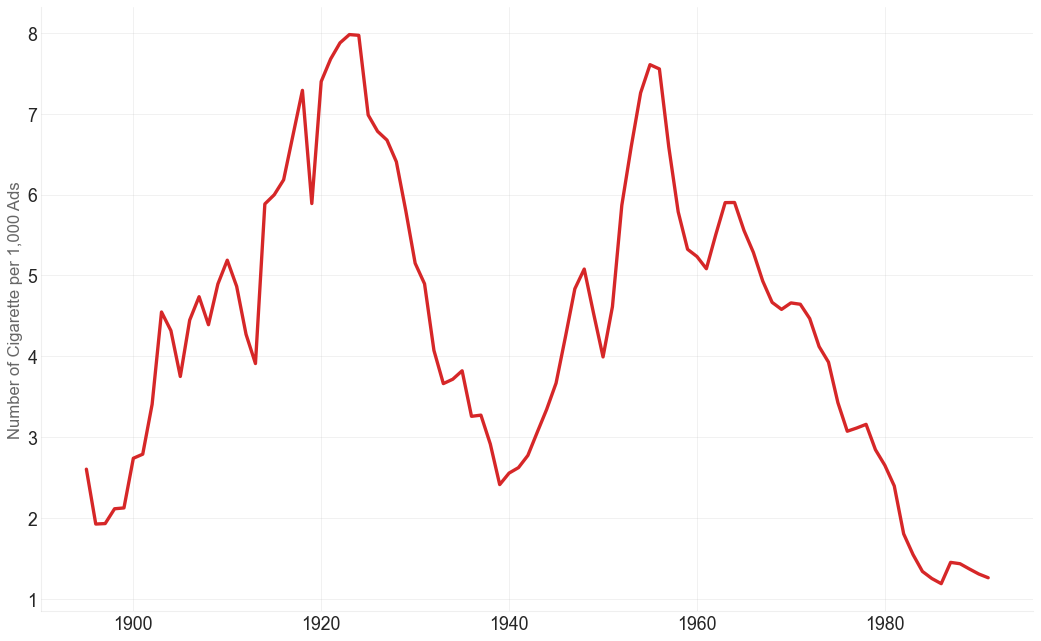

In [84]:
df = rel_count * 1000

plt.figure(figsize=(16, 10), dpi=80)
plt.plot(df.index, df.values, color='tab:red', lw=3)


#plt.title('Distribution of Cigarette Ads in Ten National Newspapers between 1890 and 1990', fontsize=18, alpha=.8)
plt.grid(axis='both', alpha=.3)

plt.ylabel(r'Number of Cigarette per 1,000 Ads', fontsize=15, alpha=.7)
#plt.xlabel(r'Year', fontsize=15, alpha=.7)

# plt.xticks(fontsize=12, alpha=.7)
# plt.yticks(fontsize=12, alpha=.7)

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)  

plt.savefig(os.path.join(figures_path, 'cigarette_ads.jpg'))
plt.show()

## Counting contex terms

In [75]:
context_term = [r'ameri[ck]a{1,2}[a-z]*', 'vere{1,2}nigde staten', 'u.s.a', 'usa']
context_term2 = [r'brits[a-z]*', 'british', 'english', 'united kingdom', 'engeland', 'vere{1,2}nigd koninkrijk']
context_term3 = [r'egypt[a-z]*']
context_term4 = [r'virginia[a-z]*']
context_term5 = [r'turkish', 'turkije', 'turks[a-z]*']
context_term6 = [r'rusland', 'russian', 'russisch[a-z]*']
span = (-5, 5)
    

In [76]:
cigarette_corpus['american'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term))
cigarette_corpus['british'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term2))
cigarette_corpus['egyptian'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term3))
cigarette_corpus['virginia'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term4))
cigarette_corpus['turkish'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term5))
cigarette_corpus['russian'] = cigarette_corpus['ocr'].apply(lambda x: find_context_word(x, span, keywords, context_term6))

american
british
egyptian
virginia
turkish
russian


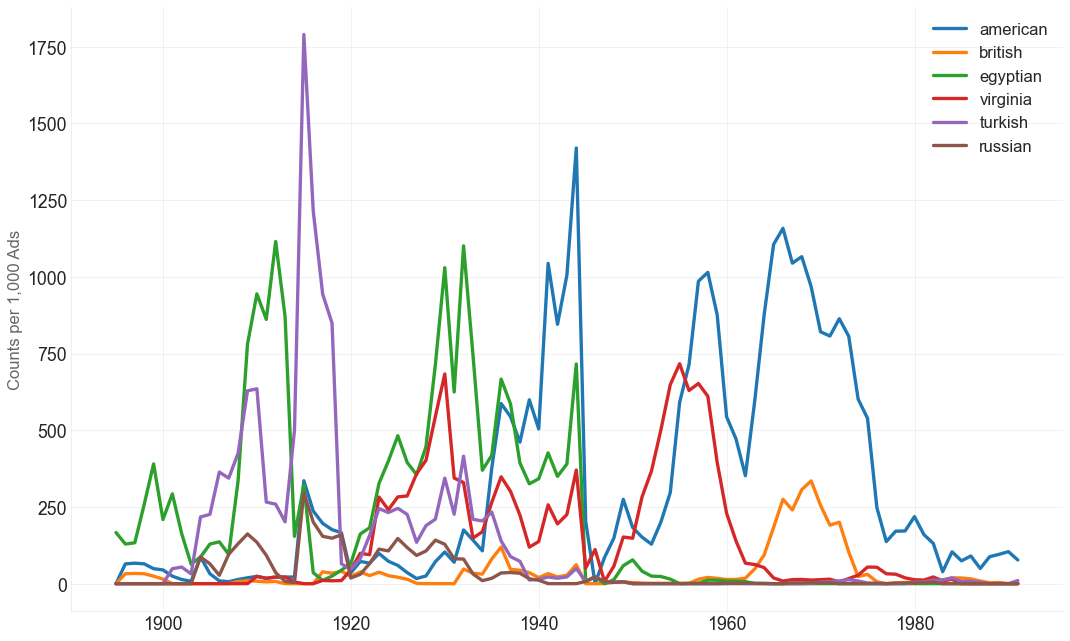

In [96]:
plot_ad_curve(cigarette_corpus,'Y', rolling=5)